# CNN on CIFAR dataset 

### CIFAR-10 by DenseNet Implementation
Cifar-10 is a popular dataset available at https://www.cs.toronto.edu/~kriz/cifar.html
We plan to solve this problem by the use of Densenet Architecture. An awesome way of solving this problem with help of Resnet is available at keras website https://keras.io/examples/cifar10_resnet/¶

### But why not Transfer Learning?
As The weights trained on ResNet or DenseNet are for ImageNet which compromises of Images of Dimension 224x224 and the image dimensions in CIFAR-10 are of 32x32 that means we cannot upsample that much anyhow. So instead we will use the same architecture of DenseNet explained in https://arxiv.org/pdf/1608.06993.pdf and will try to get as much as Accuracy possible on the dataset.
PS. We are using Google Colab for the training purpose.

In [1]:
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, Dropout, BatchNormalization, Activation, Concatenate
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import SGD, Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import cifar10
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import tensorflow as tf
from keras import backend as k

Using TensorFlow backend.


In [0]:
# Allocate the memory as needed instead of preloading
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [0]:
train_datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [0]:
# Loading the CIFAR data from the keras dataset
num_classes = 10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

In [0]:
# convert to one hot encoing 
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [10]:
x_train.shape

(50000, 32, 32, 3)

In [11]:
x_test.shape

(10000, 32, 32, 3)

In [0]:
x_train = x_train / 255
x_test = x_test / 255

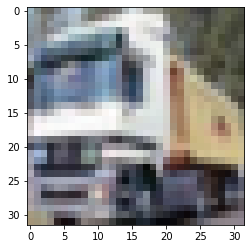

In [13]:
from matplotlib import pyplot as plt
plt.imshow(x_train[1])

In [0]:
# Dense Block
compression = 0.5
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [0]:
## transition Block
compression = 0.5
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

In [0]:
from keras import layers 

#output layer
compression = 0.5
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input) 
    relu = Activation('relu')(BatchNorm) 
    cv = Conv2D(10, (1,1), use_bias=False ,padding='same')(relu) 
    avg = AveragePooling2D(pool_size=(2,2))(cv) 
    pooling = GlobalAveragePooling2D()(avg)
    output = Activation('softmax')(pooling)
    
    return output

In [0]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 35
l = 6
num_filter = 64
compression = 0.5
dropout_rate = 0

In [23]:
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [24]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 64)   1728        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [0]:
mean = x_train.mean(0)
std = x_train.std(0)

In [0]:
def preprocess_data(dataset):
    dataset -= mean
    dataset /= std
    return dataset

In [0]:
x_train = preprocess_data(x_train)
x_test = preprocess_data(x_test)

In [0]:
# Data augementation
from keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True,
)

datagen_train.fit(x_train)

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

checkpoint_3 = ModelCheckpoint("model_dense.h5",monitor="val_acc",mode="max",save_best_only = True,verbose=1) 
NAME = 'model_dense' 
tensorboard2 = TensorBoard(log_dir='logss\{}'.format(NAME),update_freq='epoch',batch_size=batch_size) 
callbacks2 = [tensorboard2,checkpoint_3]

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [43]:
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
from keras.callbacks import ModelCheckpoint

history = model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),steps_per_epoch=(len(x_train)/batch_size)*5,
    epochs=epochs,
    verbose = 1,
    validation_data=(x_test, y_test),
)

Epoch 1/35
1954/1953 [==============================] - 348s 178ms/step - loss: 0.8636 - acc: 0.6934 - val_loss: 0.7326 - val_acc: 0.7601
Epoch 2/35
1954/1953 [==============================] - 330s 169ms/step - loss: 0.4543 - acc: 0.8426 - val_loss: 0.5687 - val_acc: 0.8151
Epoch 3/35
1954/1953 [==============================] - 331s 169ms/step - loss: 0.3417 - acc: 0.8810 - val_loss: 0.6181 - val_acc: 0.8186
Epoch 4/35
1954/1953 [==============================] - 332s 170ms/step - loss: 0.2757 - acc: 0.9040 - val_loss: 0.4066 - val_acc: 0.8688
Epoch 5/35
1954/1953 [==============================] - 331s 169ms/step - loss: 0.2287 - acc: 0.9198 - val_loss: 0.4511 - val_acc: 0.8612
Epoch 6/35
1954/1953 [==============================] - 331s 170ms/step - loss: 0.1922 - acc: 0.9328 - val_loss: 0.4016 - val_acc: 0.8775
Epoch 7/35
1954/1953 [==============================] - 331s 169ms/step - loss: 0.1650 - acc: 0.9419 - val_loss: 0.5034 - val_acc: 0.8633
Epoch 8/35
1954/1953 [============

In [45]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 5s 465us/step
Test loss: 0.5070862675895914
Test accuracy: 0.9066


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


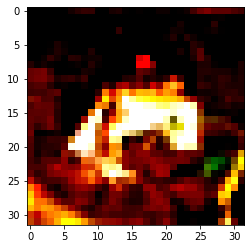

In [47]:
img_to_visualize = x_train[0]
plt.imshow(img_to_visualize)

img_to_visualize = np.expand_dims(img_to_visualize, axis=0)